In [28]:
import gym, pickle, numpy as np,random,copy,matplotlib.pyplot as plt
import connect4env

BOARD_ROWS,BOARD_COLS = 6,7
TOTAL_BOARD_SPACES = BOARD_ROWS*BOARD_COLS
COORD_TO_INDEX = lambda x : (x[0] * BOARD_ROWS) + x[1]

In [16]:
import sys,os

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
currentdir = os.path.abspath(os.getcwd())

## Player Class

Default super class that lays out defualt functions for both human and agent players.

In [17]:
class Player:
    '''
    Default player class.

    Attributes:
        name (str): Name of the player.
    '''
    def __init__(self, name):
        self.name = name
        
    def chooseAction(self, positions, curRows=None, currentBoard=None):
        pass
        
    def addState(self, state):
        pass
    
    def feedReward(self, reward):
        pass
    
    def reset(self):
        pass

## QLearning

Agents of this class use a QLearning table to keep track of rewards.  Two of these agents will play against each other during training.

In [40]:
class QAgentPlayer:
    '''
    Agent player that learns from QLearning table.

    Attributes:
        name (str) : Name of Player.
        turn (int) : Number that designates their turn.
        explRate (float) : Percentage of time agent takes a random action vs greedy action when playing (default 30%).
        states (Python list) : All positions taken in current game
        lr (float) : Learning Rate, used when feeding reward.
        decayGamma (float) : Used when feeding reward.
        statesValue (Python dict) : QLearning table. Stoes total reward for each possible game state.
    '''
    def __init__(self, name, turn, explRate=.3):
        '''
        Constructor for QAgentPlayer class.

        Parameters:
            name (str) : Name of Player.
            turn (int) : Number that designates their turn.
            explRate (float) : Percentage of time agent takes a random action vs greedy action when playing (default 30%).
        '''
        self.name = name
        self.turn = turn
        self.explRate = explRate
        self.states = []
        self.lr = .2
        self.decayGamma = .9
        self.statesValue = {}
        
    def getHash(self, board):
        '''
        Get a unique hash value that corresponds with the given board state.
        
        Parameters:
            board (np.ndarray) : Current board (from environment).
        
        Returns:
            str: Hash value of board.
        '''
        return str(board.reshape(BOARD_ROWS * BOARD_COLS))
    
    def addState(self, state):
        '''
        Adds a state to the Players state attribute
        
        Parameters:
            state (str) : Put state's hash value into self.states after choosing action.
        '''
        self.states.append(state)
        
    def chooseAction(self, openPositions, curRows=None, currentBoard=None):
        '''
        Choose an action to take using epsilon-greedy method.
        
        Parameters:
            openPositions (Python list) : List of available places to make a move on board.
            currentBoard (np.ndarray) : Game board.
        
        Returns:
            int: Position of board that agent wants to make a move.
        '''
        # Possible random action
        index = np.random.choice(len(openPositions))
        action = openPositions[index]
        secondAction = action
        maxValue = -999
                    
        if np.random.uniform(0,1) > self.explRate:
            secondMax = -999
            for p in openPositions:
                nextBoard = currentBoard.copy()
                nextBoard[p] = self.turn
                nextBoardHash = self.getHash(nextBoard)
                value = 0 if self.statesValue.get(nextBoardHash) is None else self.statesValue.get(nextBoardHash)
                if value > maxValue:
                    secondMax = maxValue
                    secondAction = action
                    maxValue = value
                    action = p
        if maxValue <= 0:
            # If agent can't find a best move, pick a random one anyways
            index = np.random.choice(len(openPositions))
            action = openPositions[index]
            secondAction = action
        # 20% of the time actually choose the second best action, for variance in decision making
        return action if np.random.uniform(0,1) > 0.2 else secondAction
    
    def feedReward(self, reward):
        '''
        At the end of the game, backpropogate and update state values.
        The updated value of state t equals the current value of state t
            adding the difference between the value of next state and the value of current state,
            which is multiplied by a learning rate α (Given the reward of intermediate state is 0).
        
        Parameters:
            reward (float) : The reward determined by the environment.
        '''
        for state in (reversed(self.states)):
            if self.statesValue.get(state) is None:
                self.statesValue[state] = 0
            self.statesValue[state] += self.lr * (self.decayGamma * reward - self.statesValue[state])
            reward = self.statesValue[state]
    
    def reset(self):
        '''
        Reset board when agent starts a new game.
        '''
        self.states = []

    def savePolicy(self):
        '''
        After training, an agent has its policy stored in self.stateValues.
        This function saves that attribute in a file to play later.

        Returns:
            string : Name of file where policy is saved
        '''
        filename = currentdir + '/policies/c4_policy_' + str(self.name)
        with open(filename, 'wb') as fw:
            pickle.dump(self.statesValue, fw)
        return filename

    # Loading the policy when playing a human
    def loadPolicy(self, file):
        '''
        Reload previous self.stateValues.
        
        Parameters:
            file (str) : Name of file that has policy.
        '''
        with open(file, 'rb') as fr:
            self.statesValue = pickle.load(fr)

## Human Player

Adds functionality for human player using raw input on the cmdline.

In [19]:
class HumanPlayer(Player):
    '''
    Allows user to input moves through the cmdline.
    
    Parameters:
        openPositions (Python list) : List of available places to make a move on board.
        currentBoard (np.ndarray) : Game board.
    
    Returns:
        int: Position of board that user wants to make a move.
    '''
    def chooseAction(self, positions, curRows=None, currentBoard=None):
        while True:
            try:
                i = int(input("Input action column-> "))
            except ValueError:
                continue
            res = [l[1] for l in positions]
            if i in res:
                return (curRows[i] - 1, i)

## Getting Available Positions

How agents find possible moves

In [20]:
def availablePositions(curRows):
    '''Update vacant positions after a turn is made'''
    positions = []
    for i in range(BOARD_COLS):
        if curRows[i] > 0:
            # Coordinates need to be in tuple form
            positions.append((curRows[i] - 1, i))
    return positions

## Driver Code

The code below is how a game is started, Using 2 player objects and an instance of the tic tac toe environment.

In [32]:
def startGame(p1, p2, env):
    '''
    Initiates a game of Connect 4.

    Parameters:
        p1 (Player) : Player who takes the first move.
        p2 (Player) : Player who takes the second move.
        env (Connect4Env) : Environment for the game.

    Returns:
        
    ''' 
    gameOver = False
    human = p1.name == "human" or p2.name == "human"
    observation = env.curRows
    while not gameOver:
        # Player 1
        openPositions = availablePositions(observation)
        observation,reward,gameOver,actionHash = env.step(p1.chooseAction(openPositions, curRows=observation, currentBoard=env.board))
        p1.addState(actionHash)
        # When there's a human player, print out stuff
        if human:
            env.render()
        if gameOver:
            if human and reward[0] == 1:
                print(f"{p1.name} wins!")
            elif human:
                print("tie!")
            p1.feedReward(reward[0])
            p2.feedReward(reward[1])
            break
        # Player 2
        openPositions = availablePositions(observation)
        observation,reward,gameOver,actionHash = env.step(p2.chooseAction(openPositions, curRows=observation, currentBoard=env.board))
        p2.addState(actionHash)
        if human:
            env.render()
        if gameOver:
            if human:
                print(f"{p2.name} wins!")
            p1.feedReward(reward[0])
            p2.feedReward(reward[1])
            break
    env.reset()
    p1.reset()
    p2.reset()
    return 1 if reward[0] == 1 else (2 if reward[1] == 1 else 0)

## Analysis

Below is a QAgent analysis of agent performance

Use a whole set of agents so they can play different 'players'

Each agent will train with 2000 games

In [22]:
env = gym.make('connect4env-v0') #make env

In [42]:
def train(agents,numGames=2000,explRate=.3):
    for agent in agents:
        agent.lr = .2
        agent.explRate = explRate
    for i in range(numGames):
        random.shuffle(agents)
        agents[0].turn,agents[1].turn = 1,-1
        startGame(agents[0],agents[1],env)
        agents[2].turn,agents[3].turn = 1,-1
        startGame(agents[2],agents[3],env)
        agents[4].turn,agents[5].turn = 1,-1
        startGame(agents[4],agents[5],env)

def test(agents,numGames=2000):
    for agent in agents:
        agent.lr = 0
        agent.explRate = .05

    graphStats = {name:[0,0,0] for name in ['p1','p2','p3','p4','p5','p6']}

    for i in range(numGames):
        random.shuffle(agents)
        agents[0].turn,agents[1].turn = 1,-1
        result = startGame(agents[0],agents[1],env)
        if result == 0:
            graphStats[agents[0].name][2] += 1
            graphStats[agents[1].name][2] += 1
        elif result == 1:
            graphStats[agents[0].name][0] += 1
            graphStats[agents[1].name][1] += 1
        elif result == 2:
            graphStats[agents[0].name][1] += 1
            graphStats[agents[1].name][0] += 1
        agents[2].turn,agents[3].turn = 1,-1
        result = startGame(agents[2],agents[3],env)
        if result == 0:
            graphStats[agents[2].name][2] += 1
            graphStats[agents[3].name][2] += 1
        elif result == 1:
            graphStats[agents[2].name][0] += 1
            graphStats[agents[3].name][1] += 1
        elif result == 2:
            graphStats[agents[2].name][1] += 1
            graphStats[agents[3].name][0] += 1
        agents[4].turn,agents[5].turn = 1,-1
        result = startGame(agents[4],agents[5],env)
        if result == 0:
            graphStats[agents[4].name][2] += 1
            graphStats[agents[5].name][2] += 1
        elif result == 1:
            graphStats[agents[4].name][0] += 1
            graphStats[agents[5].name][1] += 1
        elif result == 2:
            graphStats[agents[4].name][1] += 1
            graphStats[agents[5].name][0] += 1
    return graphStats

def graphResults(graphStats):
    fig,axes = plt.subplots(2,3, figsize=(15,15))
    xname = ['wins','losses','ties']
    count = 0

    for i in range(2):
        for j in range(3):
            agent = agents[count]
            ax = axes[i,j]
            ax.bar(xname,graphStats[agent.name])
            ax.set_xticklabels(xname)
            ax.set_title(f'{agent.name}\'s Results')
            count += 1
    plt.show()

def createNewGeneration(agents,graphStats):
    maxScore = 0
    for agent in agents:
        agentScore = graphStats[agent.name][0] + (graphStats[agent.name][2] * .5)
        if agentScore > maxScore:
            # Agent with best score (accounting for wins and ties) will be the basis for the next generation
            survivor = agent
            maxScore = agentScore

    np1 = copy.deepcopy(survivor)
    np1.name = 'p1'
    np2 = copy.deepcopy(survivor)
    np2.name = 'p2'
    np3 = copy.deepcopy(survivor)
    np3.name = 'p3'
    np4 = copy.deepcopy(survivor)
    np4.name = 'p4'
    np5 = copy.deepcopy(survivor)
    np5.name = 'p5'
    np6 = copy.deepcopy(survivor)
    np6.name ='p6'
    return [np1,np2,np3,np4,np5,np6]

def savePolicy(agents):
    for agent in agents:
        agent.savePolicy()
        print('saved an agent:',currentdir + '/policies/ttt_policy_' + str(agent.name))

In [24]:
p1 = QAgentPlayer("p1", 1)
p2 = QAgentPlayer("p2", -1)
p3 = QAgentPlayer("p3", 1)
p4 = QAgentPlayer("p4", -1)
p5 = QAgentPlayer("p5", 1)
p6 = QAgentPlayer("p6", -1)
agents = [p1,p2,p3,p4,p5,p6]

train(agents)

In [33]:
graphStats = test(agents)

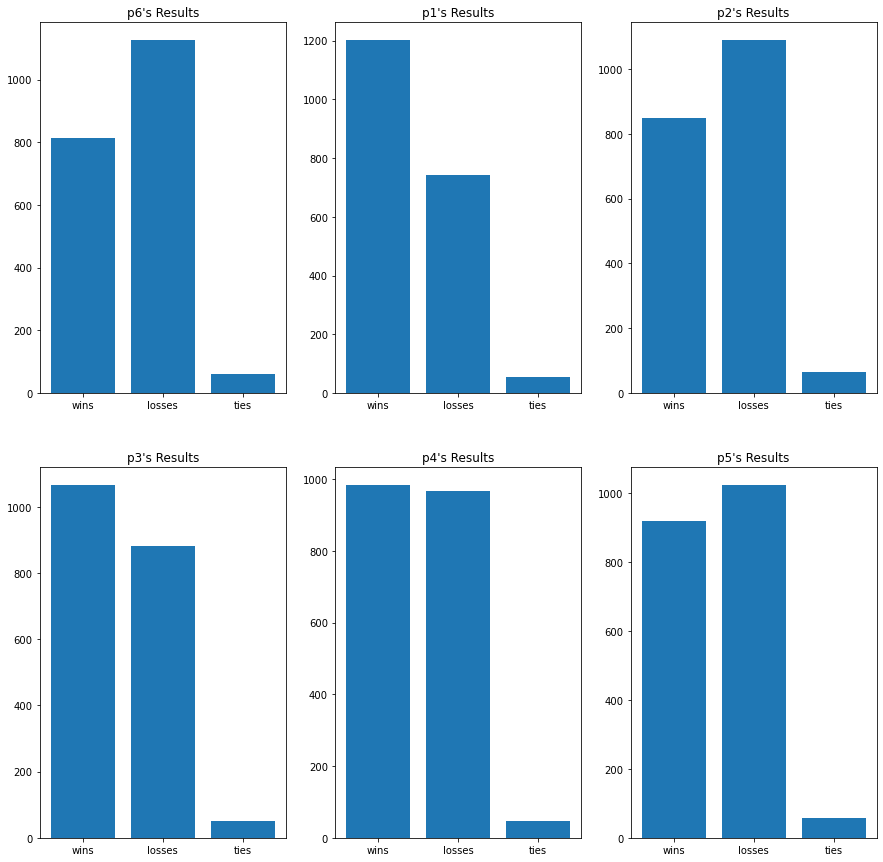

In [34]:
graphResults(graphStats)

In [35]:
agents = createNewGeneration(agents,graphStats)

train(agents)

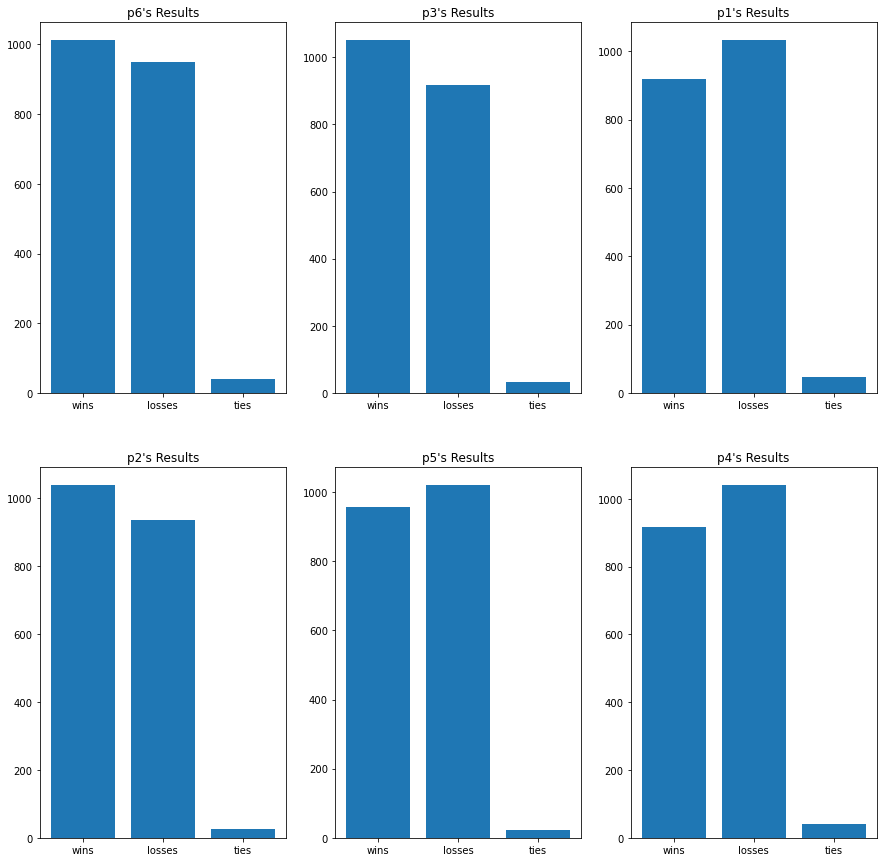

In [36]:
graphStats = test(agents)

graphResults(graphStats)

In [39]:
startGame(HumanPlayer('human'),agents[1],env)

----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   | x |   |   |   |   | 
----------------------------
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
| o |   | x |   |   |   |   | 
----------------------------
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |

1

In [43]:
p1 = QAgentPlayer("p1", 1)
p2 = QAgentPlayer("p2", -1)
p3 = QAgentPlayer("p3", 1)
p4 = QAgentPlayer("p4", -1)
p5 = QAgentPlayer("p5", 1)
p6 = QAgentPlayer("p6", -1)
agents = [p1,p2,p3,p4,p5,p6]

epochs = 10
explore = .8
for i in range(epochs-1):
    train(agents,numGames=4000,explRate=explore)
    explore -= .05
    graphStats = test(agents)
    agents = createNewGeneration(agents,graphStats)

In [44]:
savePolicy(agents)

saved an agent: c:\Users\Ethan\OneDrive\Desktop\classes\senior-project\senior-project-MARL\agent_code/policies/ttt_policy_p1
saved an agent: c:\Users\Ethan\OneDrive\Desktop\classes\senior-project\senior-project-MARL\agent_code/policies/ttt_policy_p2
saved an agent: c:\Users\Ethan\OneDrive\Desktop\classes\senior-project\senior-project-MARL\agent_code/policies/ttt_policy_p3
saved an agent: c:\Users\Ethan\OneDrive\Desktop\classes\senior-project\senior-project-MARL\agent_code/policies/ttt_policy_p4
saved an agent: c:\Users\Ethan\OneDrive\Desktop\classes\senior-project\senior-project-MARL\agent_code/policies/ttt_policy_p5
saved an agent: c:\Users\Ethan\OneDrive\Desktop\classes\senior-project\senior-project-MARL\agent_code/policies/ttt_policy_p6


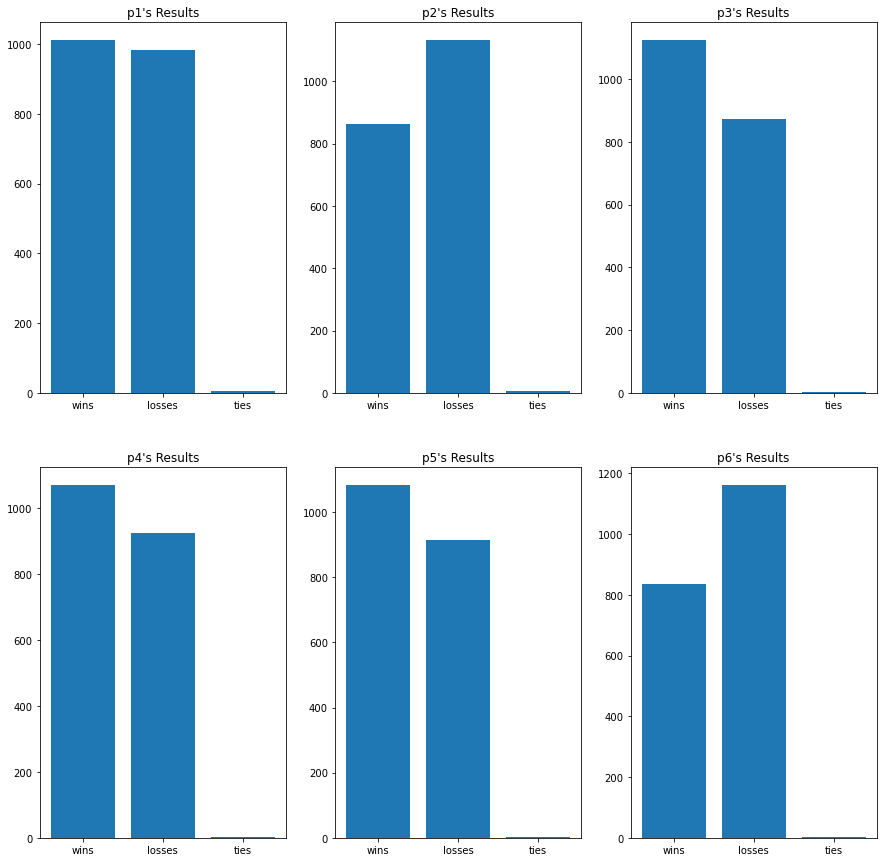

In [45]:
graphResults(graphStats)

In [48]:
startGame(agents[2],HumanPlayer('human'),env)

----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   | x |   |   |   | 
----------------------------
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   | o | x |   |   |   | 
----------------------------
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |   |   |   |   | 
----------------------------
|   |   |   |

2